In [1]:
import wfdb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

In [2]:
def rollingWindow(a, window):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

In [3]:
val = pd.read_csv('./data/validation/REFERENCE.csv', names=['id', 'type'])
val['fname'] = './data/validation/' + val.id
val['noisy'] = val.type == '~'

In [4]:
MIN_BPM = 30
MIN_FREQ = 300  # from inspection of '.hea' content
SAMPLE_WINDOW = int(60 / MIN_BPM * MIN_FREQ)
FIRST_WINDOW = int(SAMPLE_WINDOW / 2)  # avoid artifacts in the beginning of signal

In [5]:
latent_dim = 2
inner_dim = 32

def sampling(args):
    z_mean, z_log_sigma = args
    batch_size = tf.shape(z_mean)[0]
    epsilon = tf.random.normal(shape=(batch_size, latent_dim), mean=0., stddev=1.)
    return z_mean + z_log_sigma * epsilon

# Encoder
input_x = tf.keras.layers.Input(shape= (SAMPLE_WINDOW, 1)) 
h = tf.keras.layers.LSTM(inner_dim)(input_x)  #, activation='relu'

# Z
z_mean = tf.keras.layers.Dense(latent_dim)(h)
z_log_sigma = tf.keras.layers.Dense(latent_dim)(h)
z = tf.keras.layers.Lambda(sampling)([z_mean, z_log_sigma])

# Decoder
decoder = tf.keras.layers.RepeatVector(SAMPLE_WINDOW)(z)
decoder = tf.keras.layers.LSTM(inner_dim, return_sequences=True)(decoder)  #, activation='relu'
decoder = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1))(decoder)

model = tf.keras.Model(input_x, decoder)
model.load_weights('./mydata/vae/0025.ckpt')

In [6]:
def check_signal(fname):
    data, _ = wfdb.rdsamp(fname)
    sgnl = data[:, 0]
    sgnl_slices = rollingWindow(sgnl, SAMPLE_WINDOW)
    sgnl_slices_dec = model.predict(sgnl_slices[...,np.newaxis])
    noisy_flag = np.square(sgnl_slices[...,np.newaxis] - sgnl_slices_dec).mean(1) > 0.1

    flags = np.zeros(len(sgnl))
    for idx, noisy in enumerate(noisy_flag):
        if noisy:
            flags[idx:idx+SAMPLE_WINDOW] = 1
    
    _, axs = plt.subplots(2)
    axs[0].plot(sgnl)
    axs[1].plot(flags)

263/263 [==============================] - 6s 17ms/step


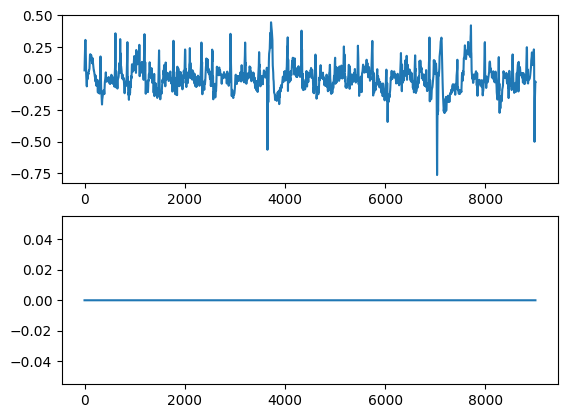

In [7]:
check_signal(val[val.noisy == True].fname.values[0])

148/148 [==============================] - 3s 17ms/step


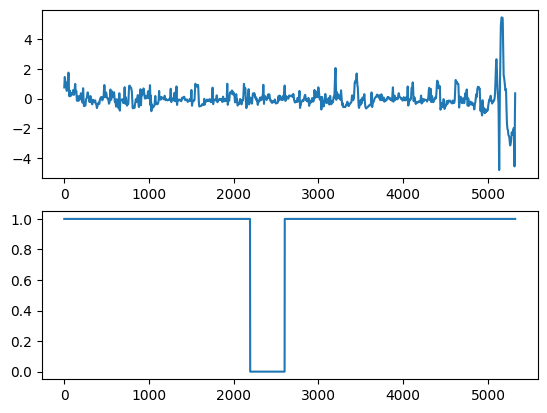

In [8]:
check_signal(val[val.noisy == True].fname.values[1])

100/100 [==============================] - 2s 17ms/step


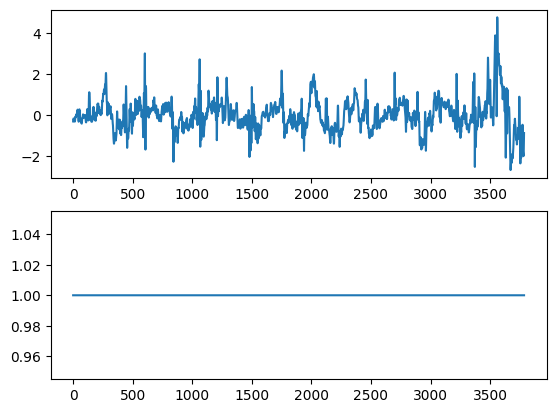

In [9]:
check_signal(val[val.noisy == True].fname.values[2])

172/172 [==============================] - 3s 17ms/step


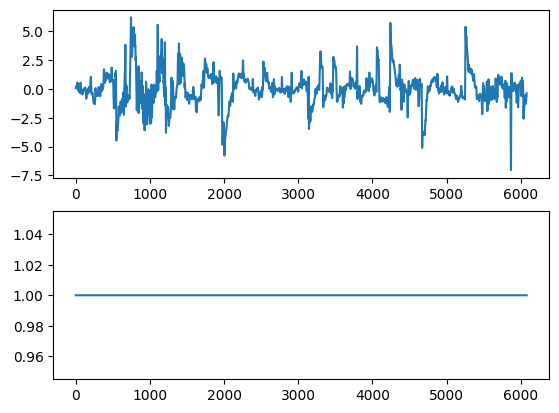

In [10]:
check_signal(val[val.noisy == True].fname.values[20])

263/263 [==============================] - 5s 17ms/step


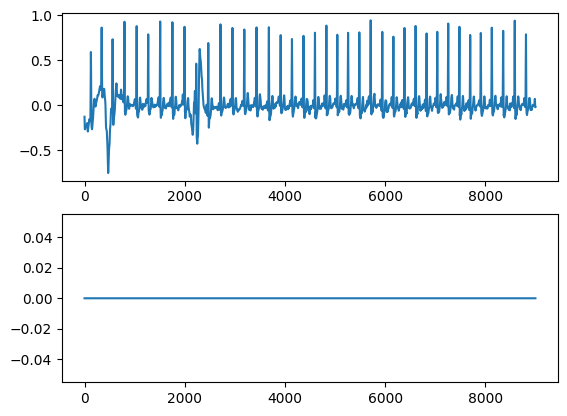

In [11]:
check_signal(val[val.noisy == False].fname.values[0])

263/263 [==============================] - 5s 17ms/step


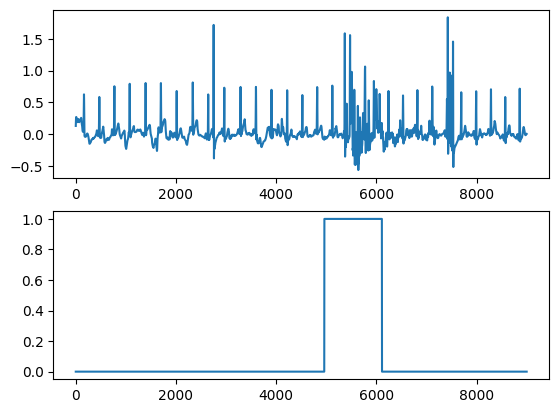

In [12]:
check_signal(val[val.noisy == False].fname.values[1])

544/544 [==============================] - 9s 17ms/step


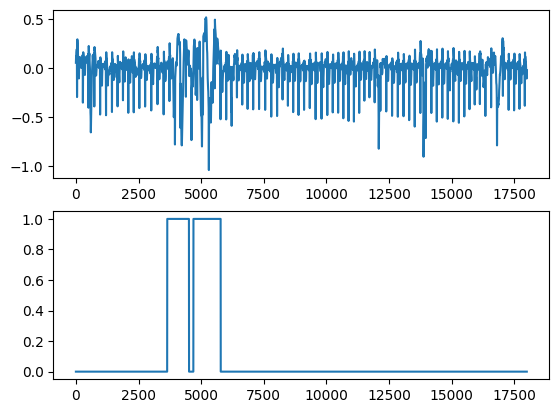

In [13]:
check_signal(val[val.noisy == False].fname.values[2])

125/125 [==============================] - 2s 17ms/step


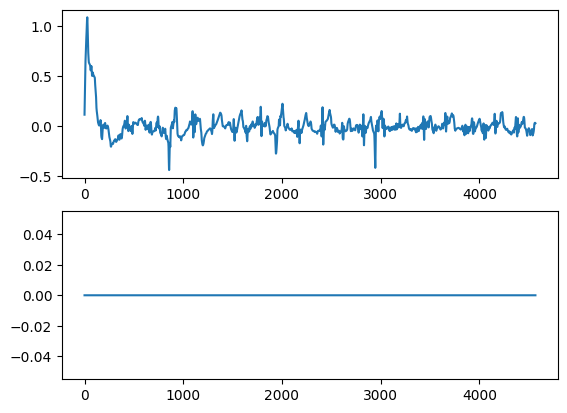

In [14]:
check_signal(val[val.noisy == False].fname.values[200])

263/263 [==============================] - 5s 17ms/step


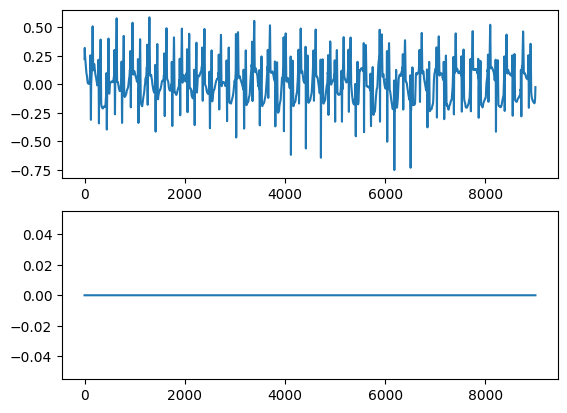

In [15]:
check_signal(val[val.noisy == False].fname.values[250])

263/263 [==============================] - 4s 17ms/step


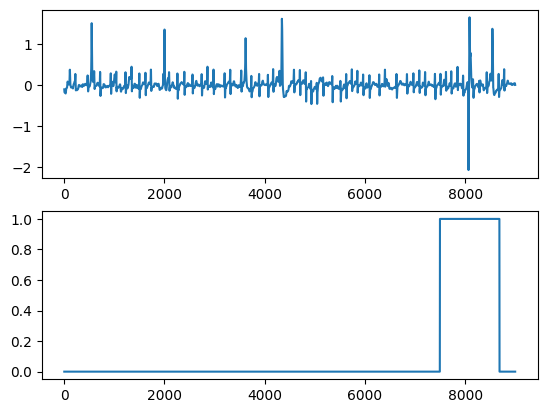

In [16]:
check_signal(val[val.noisy == False].fname.values[155])